In [236]:
#Instalamos las dependencias necesarias que no posee Google Colab.
%pip install bayesian-optimization
%pip install mlxtend --upgrade --no-deps
%pip install tensorflow
%pip install imbalanced-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [2]:
# Importamos los paquetes necesarios para el proyecto
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
import numpy as np
import json
import time


In [3]:
#Descargamos el set de datos subido previamente al Google Drive .
path_train = "UNSW_NB15_training-set.csv"
path_test = "UNSW_NB15_testing-set.csv"


#Leemos los datos
df_train=pd.read_csv(path_train,dtype='unicode')
df_test=pd.read_csv(path_test,dtype='unicode')

#print(df_train.columns)
#print(df_test.columns)

#Quitamos las columnas no necesarias
df_train.drop('id', axis=1, inplace=True)
df_train.drop('label', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)
df_test.drop('label', axis=1, inplace=True)

#print(df_train.columns)
#print(df_test.columns)

In [4]:
#Concatenamos el set de entrenamiento y el de test para manipular directamente el conjunto.
df = pd.concat([df_train,df_test],axis=0)

Shape of dataFrame: (257673, 43) 

Number of samples per attack


attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64


Plotting balance of dataFrame


<Axes: title={'center': 'Balance of dataset (%)'}, ylabel='proportion'>

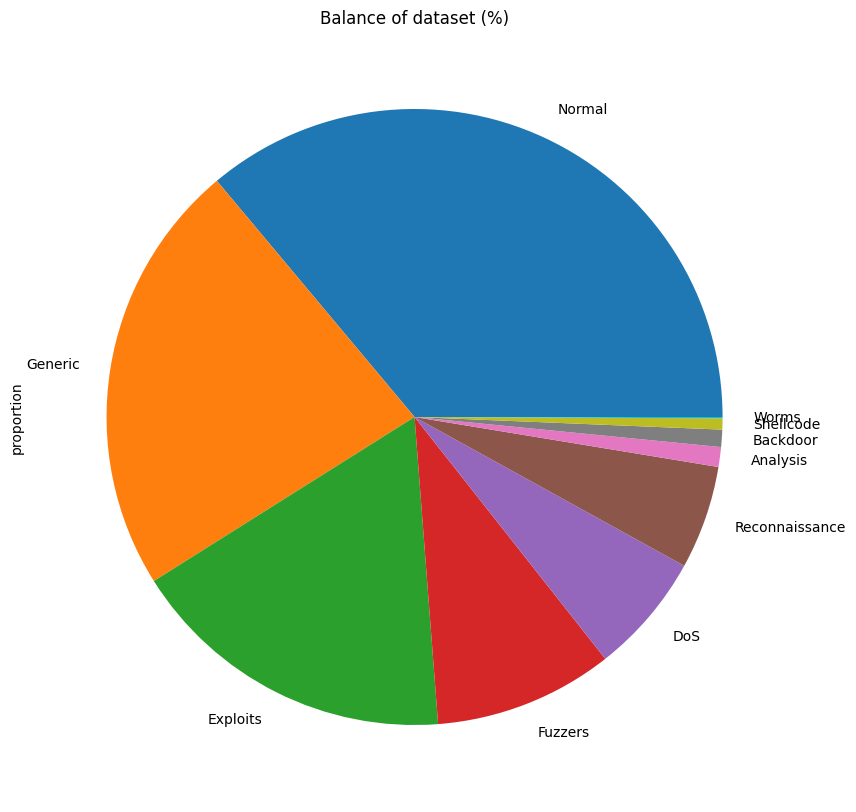

In [5]:
#Visualización en una gráfica circular del peso de cada clase
print("Shape of dataFrame: {} \n".format(df.shape))
print("Number of samples per attack")
display(df['attack_cat'].value_counts())
print("")
print("Plotting balance of dataFrame")
df_plot = (df['attack_cat'].value_counts(normalize=True) *100)
df_plot.plot(kind='pie',figsize=(10,10),title='Balance of dataset (%)')

In [6]:
#Conversión de los datos tipo string a enteros en un rango entre 0 y 255 (1 Byte de información)
def encode_string_byte (df,name):
  df[name] = LabelEncoder().fit_transform(df[name])

encode_string_byte (df,'proto')
encode_string_byte (df,'state')
encode_string_byte (df,'service')


In [7]:
#Normalización de los números enteros en valores decimales en rango entre 0 y 1
def numerical_minmax_normalization (df, name):
  x = df[name].values.reshape(-1,1)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df[name] = x_scaled

numerical_minmax_normalization(df,'dur')
numerical_minmax_normalization(df,'spkts')
numerical_minmax_normalization(df,'dpkts')
numerical_minmax_normalization(df,'sbytes')
numerical_minmax_normalization(df,'dbytes')
numerical_minmax_normalization(df,'rate')
numerical_minmax_normalization(df,'sttl')
numerical_minmax_normalization(df,'dttl')
numerical_minmax_normalization(df,'sload')
numerical_minmax_normalization(df,'dload')
numerical_minmax_normalization(df,'sloss')
numerical_minmax_normalization(df,'dloss')
numerical_minmax_normalization(df,'sinpkt')
numerical_minmax_normalization(df,'dinpkt')
numerical_minmax_normalization(df,'sjit')
numerical_minmax_normalization(df,'djit')
numerical_minmax_normalization(df,'swin')
numerical_minmax_normalization(df,'stcpb')
numerical_minmax_normalization(df,'dtcpb')
numerical_minmax_normalization(df,'dwin')
numerical_minmax_normalization(df,'tcprtt')
numerical_minmax_normalization(df,'synack')
numerical_minmax_normalization(df,'ackdat')
numerical_minmax_normalization(df,'smean')
numerical_minmax_normalization(df,'dmean')
numerical_minmax_normalization(df,'trans_depth')
numerical_minmax_normalization(df,'response_body_len')
numerical_minmax_normalization(df,'ct_srv_src')
numerical_minmax_normalization(df,'ct_state_ttl')
numerical_minmax_normalization(df,'ct_dst_ltm')
numerical_minmax_normalization(df,'ct_src_dport_ltm')
numerical_minmax_normalization(df,'ct_dst_sport_ltm')
numerical_minmax_normalization(df,'ct_dst_src_ltm')
numerical_minmax_normalization(df,'is_ftp_login')
numerical_minmax_normalization(df,'ct_ftp_cmd')
numerical_minmax_normalization(df,'ct_flw_http_mthd')
numerical_minmax_normalization(df,'ct_src_ltm')
numerical_minmax_normalization(df,'ct_srv_dst')
numerical_minmax_normalization(df,'is_sm_ips_ports')

In [8]:
#Mapeo de los valores normalizados del paso anterior a valores enteros entre 0 y 255 (1 Byte de información)
def numerical_split_ohe (df,name):
  pd_to_np = df[name].tolist()
  np_split = []

  categories = np.linspace(0, 1, num=256,endpoint=False)
  quantization = range(0,256)

  for value in pd_to_np:
    for i in range(len(categories)-1):
      if (categories[i] <= float(value) <= categories[i+1]):
        np_split.append(quantization[i])
        break
      if (float(value) > categories[-1]):
        np_split.append(quantization[-1])
        break

  df[name] = np_split


numerical_split_ohe(df,'dur')
numerical_split_ohe(df,'spkts')
numerical_split_ohe(df,'dpkts')
numerical_split_ohe(df,'sbytes')
numerical_split_ohe(df,'dbytes')
numerical_split_ohe(df,'rate')
numerical_split_ohe(df,'sttl')
numerical_split_ohe(df,'dttl')
numerical_split_ohe(df,'sload')
numerical_split_ohe(df,'dload')
numerical_split_ohe(df,'sloss')
numerical_split_ohe(df,'dloss')
numerical_split_ohe(df,'sinpkt')
numerical_split_ohe(df,'dinpkt')
numerical_split_ohe(df,'sjit')
numerical_split_ohe(df,'djit')
numerical_split_ohe(df,'swin')
numerical_split_ohe(df,'stcpb')
numerical_split_ohe(df,'dtcpb')
numerical_split_ohe(df,'dwin')
numerical_split_ohe(df,'tcprtt')
numerical_split_ohe(df,'synack')
numerical_split_ohe(df,'ackdat')
numerical_split_ohe(df,'smean')
numerical_split_ohe(df,'dmean')
numerical_split_ohe(df,'trans_depth')
numerical_split_ohe(df,'response_body_len')
numerical_split_ohe(df,'ct_srv_src')
numerical_split_ohe(df,'ct_state_ttl')
numerical_split_ohe(df,'ct_dst_ltm')
numerical_split_ohe(df,'ct_src_dport_ltm')
numerical_split_ohe(df,'ct_dst_sport_ltm')
numerical_split_ohe(df,'ct_dst_src_ltm')
numerical_split_ohe(df,'is_ftp_login')
numerical_split_ohe(df,'ct_ftp_cmd')
numerical_split_ohe(df,'ct_flw_http_mthd')
numerical_split_ohe(df,'ct_src_ltm')
numerical_split_ohe(df,'ct_srv_dst')
numerical_split_ohe(df,'is_sm_ips_ports')

In [9]:
#Quitando la columna attack_cat y guardandola en la variable y.
y_column = df['attack_cat']
df.drop('attack_cat',axis=1,inplace=True)
dummies = pd.get_dummies(y_column)
y = dummies.values

In [10]:
# Balanceo del dataset mediante SMOTE (930000 por cada clase) y normalización entre -0.5 y 0.5
x = []
for image in np.array(df.to_numpy()):
    x.append((image / 255.0) - 0.5)
x = np.array(x)  # Convertimos la lista a un array numpy

# Balanceamos el dataset usando SMOTE
sm = SMOTE(random_state=0)
x_resampled, y_resampled = sm.fit_resample(x, y)

# Verificamos las nuevas dimensiones
print("Dimensiones del dataset original:", x.shape)
print("Dimensiones del dataset resampleado:", x_resampled.shape)


Dimensiones del dataset original: (257673, 42)
Dimensiones del dataset resampleado: (930000, 42)


In [11]:
# Separación del dataset resampleado en un conjunto de entrenamiento y validación
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(x_resampled, y_resampled):
    x_train, x_test = x_resampled[train_index], x_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

# Verificar dimensiones de los conjuntos
print("Dimensiones del conjunto de entrenamiento (X):", x_train.shape)
print("Dimensiones del conjunto de validación (X):", x_test.shape)
print("Dimensiones del conjunto de entrenamiento (Y):", y_train.shape)
print("Dimensiones del conjunto de validación (Y):", y_test.shape)

Dimensiones del conjunto de entrenamiento (X): (697500, 42)
Dimensiones del conjunto de validación (X): (232500, 42)
Dimensiones del conjunto de entrenamiento (Y): (697500, 10)
Dimensiones del conjunto de validación (Y): (232500, 10)


In [12]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
if y_train.ndim > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)


Guardar-Cargar modelo

In [13]:
import os
import numpy as np
import json
import tensorflow as tf
import time

def guardar_modelo_y_data(model, history, val_dataset, y_test, model_name, training_time):
    model_folder = f"./{model_name}_files"
    os.makedirs(model_folder, exist_ok=True)
    model_path = os.path.join(model_folder, f"{model_name}_model.keras")
    model.save(model_path)
    print(f"Modelo guardado como {model_path}")
    history_path = os.path.join(model_folder, f"{model_name}_training_history.json")
    with open(history_path, 'w') as f:
        history_data = {
            "history": history.history,
            "training_time": training_time  
        }
        json.dump(history_data, f)
    print(f"Historial guardado como {history_path}")
    y_pred = model.predict(val_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)
    np.save(os.path.join(model_folder, f"y_pred_{model_name}.npy"), y_pred_classes)
    np.save(os.path.join(model_folder, f"y_true_{model_name}.npy"), y_test)
    print(f"Predicciones y etiquetas guardadas en {model_folder}")


In [14]:
import os
import numpy as np
import json
import tensorflow as tf
import time

def cargar_modelo_y_data(model_name):

    model_folder = f"./{model_name}_files"
    if not os.path.exists(model_folder):
        raise FileNotFoundError(f"La carpeta {model_folder} no existe. Verifica el nombre del modelo.")
    model_path = os.path.join(model_folder, f"{model_name}_model.keras")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    history_path = os.path.join(model_folder, f"{model_name}_training_history.json")
    with open(history_path, 'r') as f:
        history_data = json.load(f)
    print(f"Historial de entrenamiento cargado desde {history_path}")
    y_pred_path = os.path.join(model_folder, f"y_pred_{model_name}.npy")
    y_true_path = os.path.join(model_folder, f"y_true_{model_name}.npy")
    y_pred = np.load(y_pred_path)
    y_true = np.load(y_true_path)
    print(f"Predicciones cargadas desde {y_pred_path}")
    print(f"Etiquetas reales cargadas desde {y_true_path}")
    return {
        "model": model,
        "history": history_data["history"],
        "y_pred": y_pred,
        "y_true": y_true,
        "training_time": history_data["training_time"]  # Cargar el tiempo de ejecución
    }


Funciones de entrenamiento

In [272]:
import time
import numpy as np
import tensorflow as tf

# MODELO LSTM
input_layer = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
lstm_layer = tf.keras.layers.LSTM(128)(input_layer)
dropout_layer = tf.keras.layers.Dropout(0.2)(lstm_layer)
output_layer = tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')(dropout_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# COMPILAR EL MODELO
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# CREAR tf.data.Dataset
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.summary()




Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 42, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,850 (265.04 KB)

 Trainable params: 67,850 (265.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_lstm = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

In [ ]:
guardar_modelo_y_data(model, history_lstm, val_dataset, y_test, "lstm", training_time)


In [273]:
import time
import numpy as np
import tensorflow as tf

# MODELO GRU
input_layer = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
gru_layer = tf.keras.layers.GRU(128)(input_layer)
dropout_layer = tf.keras.layers.Dropout(0.2)(gru_layer)
output_layer = tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')(dropout_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# COMPILAR EL MODELO
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# CREAR tf.data.Dataset
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.summary()


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 42, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,594 (201.54 KB)

 Trainable params: 51,594 (201.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

In [ ]:
guardar_modelo_y_data(model, history_gru, val_dataset, y_test, "gru", training_time)

In [274]:
import time
import numpy as np
import tensorflow as tf

# MODELO RNN
input_layer = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
rnn_layer = tf.keras.layers.SimpleRNN(128)(input_layer)
dropout_layer = tf.keras.layers.Dropout(0.2)(rnn_layer)
output_layer = tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')(dropout_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# COMPILAR EL MODELO
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# CREAR tf.data.Dataset
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.summary()

Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 42, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,930 (70.04 KB)

 Trainable params: 17,930 (70.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_rnn = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")


In [ ]:
guardar_modelo_y_data(model, history_rnn, val_dataset, y_test, "rnn", training_time)

In [15]:
import tensorflow as tf
import numpy as np

# MODELO GRU + ATENCION ADITIVA
class Atencion_aditivo(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Atencion_aditivo, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)  # Para el estado oculto
        self.W2 = tf.keras.layers.Dense(units)  # Para las salidas del codificador
        self.V = tf.keras.layers.Dense(1)       # Para las puntuaciones

    def call(self, hidden_state, encoder_outputs):
        # hidden_state: (batch_size, units)
        # encoder_outputs: (batch_size, timesteps, units)

        # Expande el estado oculto para tener una dimensión temporal
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)  # (batch_size, 1, units)

        # Calcula las puntuaciones de atención
        score = self.V(tf.nn.tanh(self.W1(hidden_with_time_axis) + self.W2(encoder_outputs)))  # (batch_size, timesteps, 1)

        # Calcula los pesos de atención
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, timesteps, 1)

        # Calcula el vector de contexto
        context_vector = attention_weights * encoder_outputs  # (batch_size, timesteps, units)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, units)

        return context_vector, attention_weights

# MODELO GRU + ATENCION ADITIVA
def GRU_aditivo(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    gru_layer = tf.keras.layers.GRU(128, return_sequences=True, return_state=True)
    encoder_outputs, hidden_state = gru_layer(inputs)

    # Atención aditiva
    attention_layer = Atencion_aditivo(128)
    context_vector, attention_weights = attention_layer(hidden_state, encoder_outputs)
    
    # Salidas del modelo
    dropout_layer = tf.keras.layers.Dropout(0.2)(context_vector)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Configuración del modelo
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Crear el modelo
model_aditivogru = GRU_aditivo(input_shape, num_classes)

# COMPILAR EL MODELO
model_aditivogru.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Creación de tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_aditivogru.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ [(None, 42, 128), │     50,304 │ input_layer[0][0] │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ atencion_aditivo    │ [(None, 128),     │     33,153 │ gru[0][1],        │
│ (Atencion_aditivo)  │ (None, 42, 1)]    │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ atencion_aditivo… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │      1,290 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,747 (331.04 KB)

 Trainable params: 84,747 (331.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru_aditivo = model_aditivogru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)

end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")


In [ ]:
guardar_modelo_y_data(model_aditivogru, history_gru_aditivo, val_dataset, y_test, "gru_aditivo", training_time)

In [290]:
import tensorflow as tf
import numpy as np

# MODELO GRU + ATENCION GENERAL
class AtencionGeneral(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AtencionGeneral, self).__init__()
        self.Wa = tf.keras.layers.Dense(units, use_bias=False)

    def call(self, hidden_state, encoder_outputs):
        # hidden_state: (batch_size, hidden_size)
        # encoder_outputs: (batch_size, seq_len, hidden_size)
        
        # Aplicamos la transformación lineal al hidden_state
        hidden_transformed = self.Wa(hidden_state)  # (batch_size, units)
        
        # Expandimos hidden_transformed
        hidden_with_time_axis = tf.expand_dims(hidden_transformed, 1)  # (batch_size, 1, units)
        
        # Calculamos el puntaje de atención (producto escalar)
        score = tf.matmul(encoder_outputs, hidden_with_time_axis, transpose_b=True)  # (batch_size, seq_len, 1)
        
        # Aplicamos softmax
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, seq_len, 1)
        
        # Calculamos el vector de contexto
        context_vector = attention_weights * encoder_outputs  # (batch_size, seq_len, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_size)
        
        return context_vector, attention_weights

# MODELO GRU + ATENCION GENERAL
def GRU_general(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    gru_layer = tf.keras.layers.GRU(128, return_sequences=True, return_state=True)
    encoder_outputs, hidden_state = gru_layer(inputs)

    # Atención general
    attention_layer = AtencionGeneral(128)
    context_vector, attention_weights = attention_layer(hidden_state, encoder_outputs)
    
    # Salida
    dropout_layer = tf.keras.layers.Dropout(0.2)(context_vector)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Configuración del modelo
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Crear el modelo
Gru_atencion_general = GRU_general(input_shape, num_classes)

# COMPILAR EL MODELO
Gru_atencion_general.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Creación de tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Gru_atencion_general.summary()


Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_61      │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ [(None, 42, 128), │     50,304 │ input_layer_61[0… │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ atencion_general_5  │ [(None, 128),     │     16,384 │ gru_16[0][1],     │
│ (AtencionGeneral)   │ (None, 42, 1)]    │            │ gru_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 128)       │          0 │ atencion_general… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 10)        │      1,290 │ dropout_50[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,978 (265.54 KB)

 Trainable params: 67,978 (265.54 KB)

 Non-trainable params: 0 (0.00 B)

In [302]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru_general = Gru_atencion_general.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)
end_time = time.time()

training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

Epoch 1/100
   86/10899 ━━━━━━━━━━━━━━━━━━━━ 4:03 23ms/step - accuracy: 0.3314 - loss: 1.7953

KeyboardInterrupt: 

In [ ]:
guardar_modelo_y_data(Gru_atencion_general, history_gru_general, val_dataset, y_test, "gru_general", training_time)

In [ ]:
import tensorflow as tf
import numpy as np

# MODELO GRU + ATENCIÓN PRODUCTO PUNTO
class AtencionDotProduct(tf.keras.layers.Layer):
    def call(self, hidden_state, encoder_outputs):
        # hidden_state: (batch_size, hidden_size)
        # encoder_outputs: (batch_size, seq_len, hidden_size)
        
        # Expandimos el hidden_state para que coincida con el encoder_outputs
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
        
        # Calculamos el puntaje de atención
        score = tf.matmul(encoder_outputs, hidden_with_time_axis, transpose_b=True) # (batch_size, seq_len, 1)
        
        # Aplicamos softmax
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, seq_len, 1)
        
        # Calculamos el vector de contexto
        context_vector = attention_weights * encoder_outputs  # (batch_size, seq_len, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_size)
        
        return context_vector, attention_weights

# MODELO GRU + ATENCIÓN PRODUCTO PUNTO
def GRU_dotproduct(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    gru_layer = tf.keras.layers.GRU(128, return_sequences=True, return_state=True)
    encoder_outputs, hidden_state = gru_layer(inputs)

    # Atención por producto punto local
    attention_layer = AtencionDotProduct()
    context_vector, attention_weights = attention_layer(hidden_state, encoder_outputs)
    
    # Salida
    dropout_layer = tf.keras.layers.Dropout(0.2)(context_vector)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Configuración del modelo
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Crear el modelo
Gru_atencion_dotproduct = GRU_dotproduct(input_shape, num_classes)

# COMPILAR EL MODELO
Gru_atencion_dotproduct.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Creación de tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

Gru_atencion_dotproduct.summary()

Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_67      │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_22 (GRU)        │ [(None, 42, 128), │     50,304 │ input_layer_67[0… │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product_attent… │ [(None, 128),     │          0 │ gru_22[0][1],     │
│ (DotProductAttenti… │ (None, 42, 1)]    │            │ gru_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 128)       │          0 │ dot_product_atte… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_109 (Dense)   │ (None, 10)        │      1,290 │ dropout_56[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,594 (201.54 KB)

 Trainable params: 51,594 (201.54 KB)

 Non-trainable params: 0 (0.00 B)

In [303]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru_dotproduct = Gru_atencion_dotproduct.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)
end_time = time.time()

training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

Epoch 1/100
  124/10899 ━━━━━━━━━━━━━━━━━━━━ 3:15 18ms/step - accuracy: 0.1088 - loss: 2.3029

KeyboardInterrupt: 

In [ ]:
guardar_modelo_y_data(Gru_atencion_dotproduct, history_gru_dotproduct, val_dataset, y_test, "gru_dotproduct", training_time)

In [ ]:
import tensorflow as tf
import numpy as np

# MODELO GRU + PRODUCTO PUNTO ESCALADO
class Atencion_EscaladoDotProduct(tf.keras.layers.Layer):
    def call(self, inputs):
        query, key, value = inputs  # Desempaquetamos los inputs

        # query: (batch_size, query_len, d_k)
        # key: (batch_size, key_len, d_k)
        # value: (batch_size, key_len, d_v)

        # Calcular scores de atención
        scores = tf.matmul(query, key, transpose_b=True)  # (batch_size, query_len, key_len)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_scores = scores / tf.math.sqrt(dk)

        # Aplicar softmax para obtener pesos de atención
        attention_weights = tf.nn.softmax(scaled_scores, axis=-1)  # (batch_size, query_len, key_len)

        # Generar vector de contexto
        context = tf.matmul(attention_weights, value)  # (batch_size, query_len, d_v)
        return context, attention_weights

# MODELO GRU + PRODUCTO PUNTO ESCALADO
def GRU_EscaladoDotProduct(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # GRU para codificación
    gru_layer = tf.keras.layers.GRU(128, return_sequences=True)
    encoder_outputs = gru_layer(inputs)  # (batch_size, timesteps, units)

    # Obtener el último estado oculto
    hidden_state = encoder_outputs[:, -1, :]  # (batch_size, units)

    # Expandir dimensiones del hidden_state
    hidden_state_expanded = tf.keras.layers.Reshape((1, 128))(hidden_state)  # (batch_size, 1, units)

    # Atención producto punto escalado
    attention_layer = Atencion_EscaladoDotProduct()
    context_vector, attention_weights = attention_layer([
        hidden_state_expanded,  # Query de forma (batch_size, 1, units)
        encoder_outputs,        # Key de forma (batch_size, timesteps, units)
        encoder_outputs         # Value de forma (batch_size, timesteps, units)
    ])

    # Aplanar el vector de contexsto
    context_vector = tf.keras.layers.Flatten()(context_vector)  # (batch_size, units)

    # Salidas del modelo
    dropout_layer = tf.keras.layers.Dropout(0.2)(context_vector)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout_layer)

    # Crear el modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Configuración del modelo
input_shape = (x_train.shape[1], x_train.shape[2])  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Crear el modelo
GRU_EscaladoDotProduct_model = GRU_EscaladoDotProduct(input_shape, num_classes)

# COMPILAR EL MODELO
GRU_EscaladoDotProduct_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Crear tf.data.Dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Configurar Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.summary()


Model: "functional_97"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_79      │ (None, 42, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_36 (GRU)        │ (None, 42, 128)   │     50,304 │ input_layer_79[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 128)       │          0 │ gru_36[0][0]      │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 128)    │          0 │ get_item_12[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_dot_product… │ [(None, 1, 128),  │          0 │ reshape_2[0][0],  │
│ (ScaledDotProductA… │ (None, 1, 42)]    │            │ gru_36[0][0],     │
│                     │                   │            │ gru_36[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 128)       │          0 │ scaled_dot_produ… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 128)       │          0 │ flatten_2[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_113 (Dense)   │ (None, 10)        │      1,290 │ dropout_59[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,594 (201.54 KB)

 Trainable params: 51,594 (201.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# REGISTRAR TIEMPO DE EJECUCIÓN
start_time = time.time()

# ENTRENAR EL MODELO
history_gru_dotproduct_escalado = GRU_EscaladoDotProduct_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping],
)
end_time = time.time()
training_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")



In [ ]:
guardar_modelo_y_data(GRU_EscaladoDotProduct_model, history_gru_dotproduct_escalado, val_dataset, y_test, "gru_escalado_dotproduct", training_time)

Funciones de visualización

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def Matriz_confusion_binaria(y_true, y_pred, output_path='binary_confusion_matrix.csv'):
    # Crear matriz binaria (1 para ataque, 0 para normal)
    binary_y_true = [0 if label == 'Normal' else 1 for label in y_true]
    binary_y_pred = [0 if label == 'Normal' else 1 for label in y_pred]

    # Matriz de confusión binaria
    binary_conf_matrix = confusion_matrix(binary_y_true, binary_y_pred)

    # Guardar la matriz binaria
    np.savetxt(output_path, binary_conf_matrix, delimiter=',', fmt='%d')

    # Graficar matriz de confusión binaria
    plt.figure(figsize=(6, 6))
    sns.heatmap(binary_conf_matrix, annot=True, fmt='d', cmap='Reds')
    plt.title('Binary Confusion Matrix (Attack vs Normal)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
 

In [238]:
def Matriz_confusion_general(y_true, y_pred, labels, output_path='confusion_matrix.csv'):
    # Crear la matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Guardar la matriz de confusión
    np.savetxt(output_path, conf_matrix, delimiter=',', fmt='%d')

    # Graficar la matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [239]:
def Graficar_precision(history, output_path='accuracy_plot.png'):
    # Graficar precisión
    plt.figure(figsize=(10, 6))
    plt.plot(history['accuracy'], label='Train Accuracy', linestyle='-', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='s')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(output_path)
    plt.show()


In [240]:
def Graficar_perdida(history, output_path='loss_plot.png'):
    # Graficar pérdida
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss', linestyle='-', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', linestyle='--', marker='s')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(output_path)
    plt.show()
